In [14]:
import tdt
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tkinter import Tk
from tkinter import filedialog
from readSGLX import readMeta, SampRate, makeMemMapRaw, ExtractDigital
from sklearn.linear_model import LinearRegression
from scipy.io import savemat
from warnings import warn
from barcodes import extract_barcodes_from_times

In [2]:
def plot_pulses(onset_times, offset_times, nPulsesToPlot=20):
    '''Use onset and offset times to plot pulse waveforms. 
    Times should be in seconds. Plot only the first N pulses (default 100)'''
    
    #Interleave onset and offset times
    edge_times = np.empty((onset_times.size + offset_times.size,), dtype=onset_times.dtype)
    edge_times[0::2] = onset_times
    edge_times[1::2] = offset_times
    
    # Figure out when pulses are high and when they are low
    sync_levels = np.empty((onset_times.size + offset_times.size,), dtype=onset_times.dtype)
    sync_levels[0::2] = 1
    sync_levels[1::2] = 0

    plt.figure(num=None, figsize=(30, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.step(edge_times[:nPulsesToPlot], sync_levels[:nPulsesToPlot], where='post')

# Load SGLX

In [3]:
def select_sglx_file():
    '''Select a SGLX binary file to extract the digtial sync bit from. 
    Using the LFP file is faster, but the AP file is maximally precise.'''

    
    # Get file from user
    root = Tk()         # create the Tkinter widget
    root.withdraw()     # hide the Tkinter root window

    # Windows specific; forces the window to appear in front
    root.attributes("-topmost", True)

    fullPath = Path(filedialog.askopenfilename(title="Select SpikeGLX binary file"))

    root.destroy()
    
    return fullPath

In [4]:
def sglx_load_sync(sglx_file):
    '''Load the sync channel from the specified binary file. 
    The SpikeGLX metadata file must be present in the same directory as the binary file.'''
    meta = readMeta(sglx_file)
    rawData = makeMemMapRaw(sglx_file, meta)

    # Read the entire file
    firstSamp = 0
    lastSamp = rawData.shape[1]-1

    # Which digital word to read. 
    # For imec, there is only 1 digital word, dw = 0.
    # For NI, digital lines 0-15 are in word 0, lines 16-31 are in word 1, etc.
    dw = 0    
    # Which lines within the digital word, zero-based
    # Note that the SYNC line for PXI 3B is stored in line 6.
    dLineList = [6]
        
    return ExtractDigital(rawData, firstSamp, lastSamp, dw, dLineList, meta)

In [5]:
def sglx_onset_samples(sync):
    '''Extract the pulse rising edge samples from the SGLX sync channel.'''
    # Onsets are the first samples where a value is high after being low. If sample 0 is high, the first onset is sample 0. Consistent with TDT convention.
    onset_samples = np.where(np.diff(np.squeeze(sync), prepend=0) == 1)[0]
    assert(onset_samples.dtype == np.dtype('int64')) # Make sure uint8s have been properly casted as int64s
    return onset_samples

In [6]:
def sglx_offset_samples(sync):
    '''Extract the pulse falling edge samples from the SGLX sync channel'''
    # Offsets are the first samples wehre a value is low after being high. If the last sample is high, the last offset is Inf. Consistent with TDT convention.
    offset_samples = np.where(np.diff(np.squeeze(sync), prepend=0) == -1)[0]
    assert(offset_samples.dtype == np.dtype('int64')) # Make sure uint8s have been properly casted as int64s
    if np.squeeze(sync)[-1] == 1:
        offset_samples = np.append(offset_samples, np.Inf)
    return offset_samples

In [7]:
def get_rising_edges(onset_times):
    '''Assumes onset times follow TDT convention, as described above.'''
    return onset_times[np.where(onset_times > 0)]

In [8]:
def get_falling_edges(offset_times):
    '''Assumes offset times follow TDT convention, as described above '''
    return offset_times[np.where(offset_times < np.Inf)]

In [11]:
sglx_file = select_sglx_file()
sglx_sync = sglx_load_sync(sglx_file)
sglx_fs = SampRate(readMeta(sglx_file))
# Times are in seconds from the start of the SGLX recording. 
sglx_onset_times = sglx_onset_samples(sglx_sync) / sglx_fs
sglx_offset_times = sglx_offset_samples(sglx_sync) / sglx_fs

nChan: 385, nFileSamp: 1877279


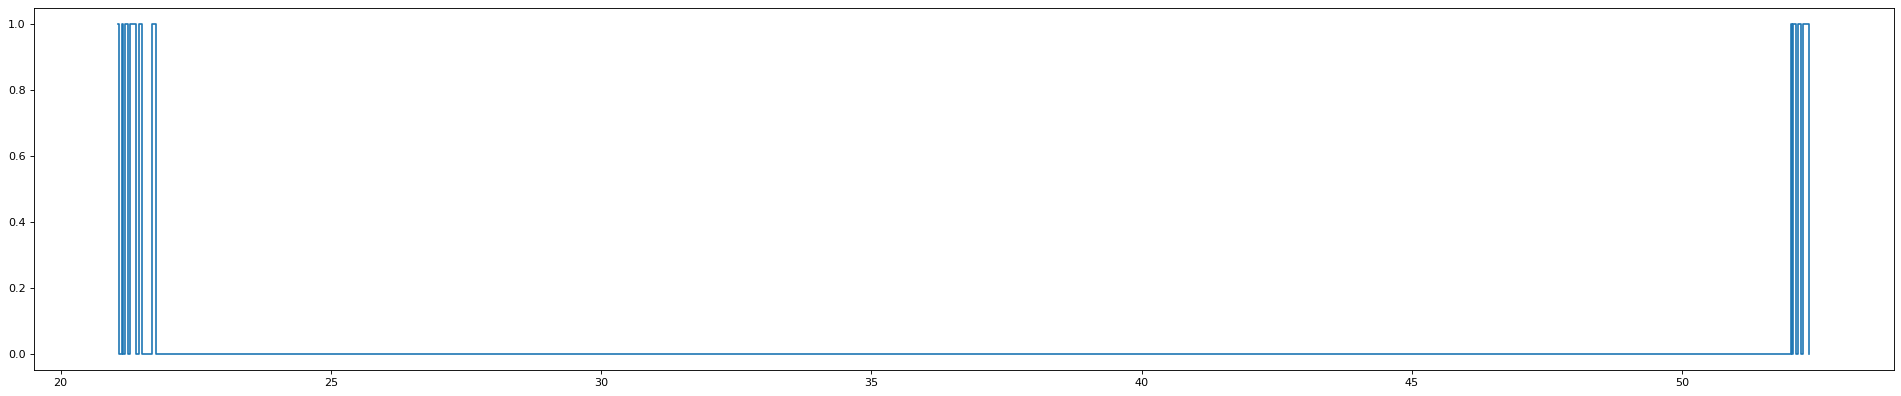

In [13]:
plot_pulses(sglx_onset_times, sglx_offset_times, nPulsesToPlot=20)

In [15]:
sglx_rising_edges = get_rising_edges(sglx_onset_times)
sglx_falling_edges = get_falling_edges(sglx_offset_times)
sglx_barcode_start_times, sglx_barcodes = extract_barcodes_from_times(sglx_rising_edges, sglx_falling_edges, bar_duration=0.029)

# Load TDT

In [16]:
def select_tdt_block():
    '''Select a TDT block to extract sync info from.'''
    # Get file from user
    root = Tk()         # create the Tkinter widget
    root.withdraw()     # hide the Tkinter root window

    # Windows specific; forces the window to appear in front
    root.attributes("-topmost", True)

    fullPath = Path(filedialog.askdirectory(title="Select TDT block"))

    root.destroy()
    
    return fullPath

In [17]:
tdt_file = select_tdt_block()
tdt_data = tdt.read_block(tdt_file, evtype=['epocs'])
# Here, we assume that your digital sync pulse is recorded on Port C0
# YSK: TDT calls the onset of a signal that starts high "0", but the offset of a signal that ends high "inf"
# Times are in seconds from the start of the TDT recording. 
tdt_onset_times = tdt_data.epocs.PC0_.onset 
tdt_offset_times = tdt_data.epocs.PC0_.offset

read from t=0s to t=750.38s


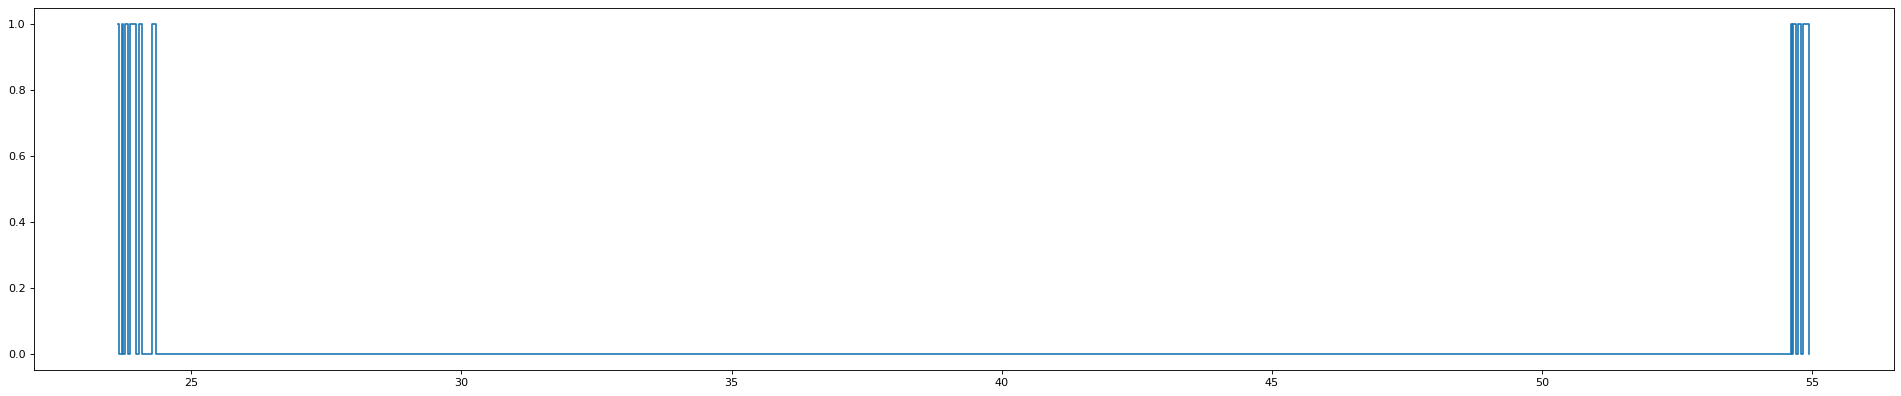

In [18]:
plot_pulses(tdt_onset_times, tdt_offset_times, nPulsesToPlot=20)

In [19]:
tdt_rising_edges = get_rising_edges(tdt_onset_times)
tdt_falling_edges = get_falling_edges(tdt_offset_times)
tdt_barcode_start_times, tdt_barcodes = extract_barcodes_from_times(tdt_rising_edges, tdt_falling_edges, bar_duration=0.029)

# Use barcodes to align streams

In [20]:
print(sglx_barcode_start_times)
print(tdt_barcode_start_times)

[ 52.01945607  82.9781704  113.93648475 144.89479909 175.85351343
 206.81182777 237.77014211 268.72885645 299.68717079 330.64588512
 361.60419947 392.5629138  423.52122814 454.47954249 485.43825682
 516.39657117 547.3552855  578.31359984 609.27191419 640.23062852
 671.18894286 702.14725721 733.10597154]
[ 54.60656128  85.56515328 116.52370432 147.48229632 178.44088832
 209.39948032 240.35803136 271.31662336 302.27521536 333.23380736
 364.19239936 395.15099136 426.10958336 457.06817536 488.0267264
 518.9853184  549.94395136 580.9025024  611.8610944  642.8196864
 673.77823744 704.73682944 735.69538048]


*The following barcode sequences should match exactly. If they do not, we must find the longest common subsequence of matching barcodes.*

In [22]:
# These should match
print(sglx_barcodes)
print(tdt_barcodes)

[2070601.0, 2070599.0, 2070597.0, 2070595.0, 2070593.0, 2070591.0, 2070589.0, 2070587.0, 2070585.0, 2070583.0, 2070581.0, 2070579.0, 2070577.0, 2070575.0, 2070573.0, 2070571.0, 2070569.0, 2070567.0, 2070565.0, 2070563.0, 2070561.0, 2070559.0, 2070557.0]
[2070601.0, 2070599.0, 2070597.0, 2070595.0, 2070593.0, 2070591.0, 2070589.0, 2070587.0, 2070585.0, 2070583.0, 2070581.0, 2070579.0, 2070577.0, 2070575.0, 2070573.0, 2070571.0, 2070569.0, 2070567.0, 2070565.0, 2070563.0, 2070561.0, 2070559.0, 2070557.0]


In [24]:
assert (sglx_barcodes == tdt_barcodes), "The barcode sequences must match exactly. TODO: Fix this by automatically finding longest common subsequence."

# Fit the TDT barcode times to the SGLX barcode times
y = sglx_barcode_start_times
x = tdt_barcode_start_times.reshape((-1, 1))
model = LinearRegression().fit(x, y)
r_sq = model.score(x, y)

In [59]:
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('drift rate in msec/hr:', (model.coef_[0] - 1)*60*60*1000)

coefficient of determination: 0.9999999999996882
intercept: -2.58683415383382
drift rate in msec/hr: -13.005901819918009


In [33]:
def visualize_mapping(sglx_rising_edges, tdt_rising_edges, model, nPulsesToPlot=10):
    '''Visualize remapped TDT sync pulse times in SGLX time space, to verify correctness.
    Black lines = Pulse times measured by SGLX.
    Red lines = Pulse times measured by TDT and remapped to SGLX time space. '''
    remapped_tdt_times = model.predict(tdt_rising_edges.reshape((-1, 1)))
    
    plt.figure(num=None, figsize=(30, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.vlines(sglx_rising_edges[:nPulsesToPlot], 0, 1, colors='black')
    plt.vlines(remapped_tdt_times[:nPulsesToPlot], 0, 1, linestyle='dotted', colors='red')

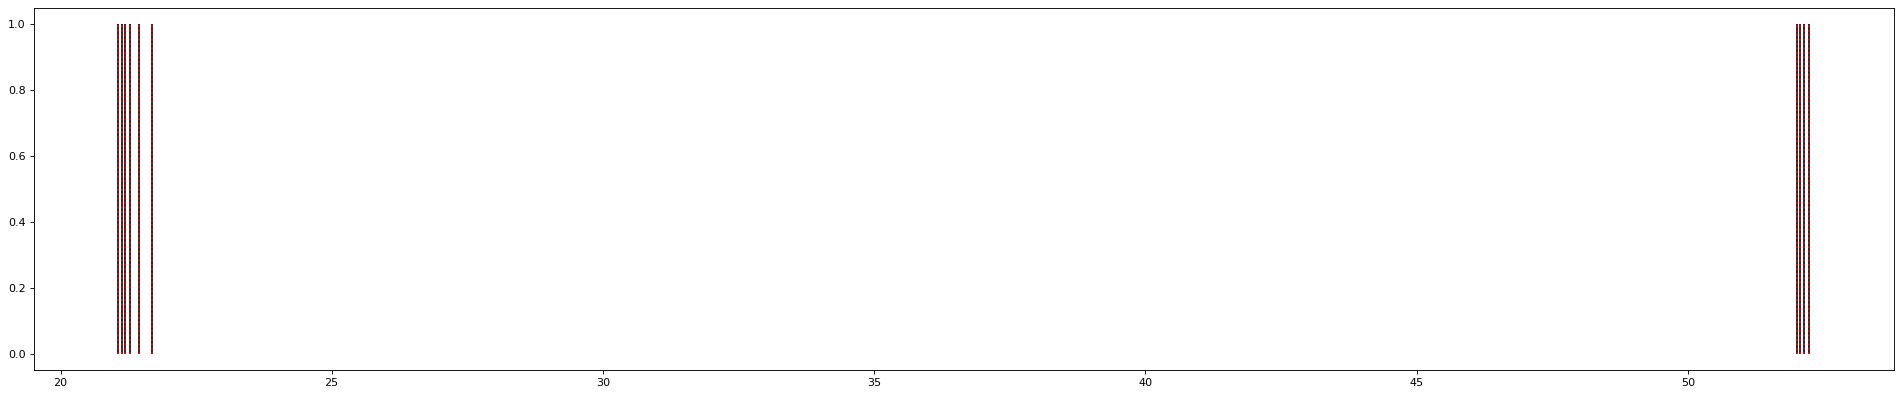

In [34]:
visualize_mapping(sglx_rising_edges, tdt_rising_edges, model)

# Get TDT stimulation times

In [35]:
def get_stim_times(tdt_data):
    '''Extract the time of each stimulation from a loaded TDT block.
    Times are in seconds from the start of the TDT recording.'''
    CntA = tdt_data.epocs.CntA 
    PeA_ = tdt_data.epocs.PeA_
    
    n_strobes = np.size(PeA_.onset) 
    stim_t = np.array([])
    
    for strobe in np.arange(n_strobes):
        strobe_ISI = PeA_.data[strobe] / 1000 # Convert from msec to sec
        n_strobe_stims = CntA.data[strobe] # The number of stimlations in this strobe
        strobe_start = PeA_.onset[strobe] # The time that this strobe started
        strobe_stims = strobe_start + np.arange(n_strobe_stims) * strobe_ISI # The time of each stimulation in this strobe
        stim_t = np.append(stim_t, strobe_stims)
        
    return stim_t  

In [36]:
def get_stim_samples(tdt_data):
    '''Get the sample numbers of each stimulation, based on epoc store estimates.'''
    eS1r = tdt_data.streams.eS1r
    stim_times = get_stim_times(tdt_data)
    return np.rint(stim_times * eS1r.fs).astype('int')

In [37]:
tdt_data = tdt.read_block(tdt_file, evtype=['epocs', 'streams'])
stim_times = get_stim_times(tdt_data)

read from t=0s to t=750.38s


In [55]:
def visualize_stims(tdt_data, ch, first_stim=0, last_stim=4, before=100, after=100):
    '''Visualize estimated stimulation times (block dotted lines) relative to the stimulator current stream.
    first_stim is the 0-based index of the first stimulation to plot.
    last_stim is the 0-based index of the last stimulation to plot. 
    before/after are the number of samples to plot before the first stim and after the last stim.
    ch is the stimulator current channel to plot.'''
    stim_samples = get_stim_samples(tdt_data)
    samplesToPlot = np.arange(stim_samples[first_stim] - before, stim_samples[last_stim] + after)

    plt.figure(num=None, figsize=(30, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(samplesToPlot, tdt_data.streams.eS1r.data[ch, samplesToPlot])
    plt.vlines(stim_samples[first_stim : last_stim + 1], 0, 1000, linestyle='dotted', colors='black')

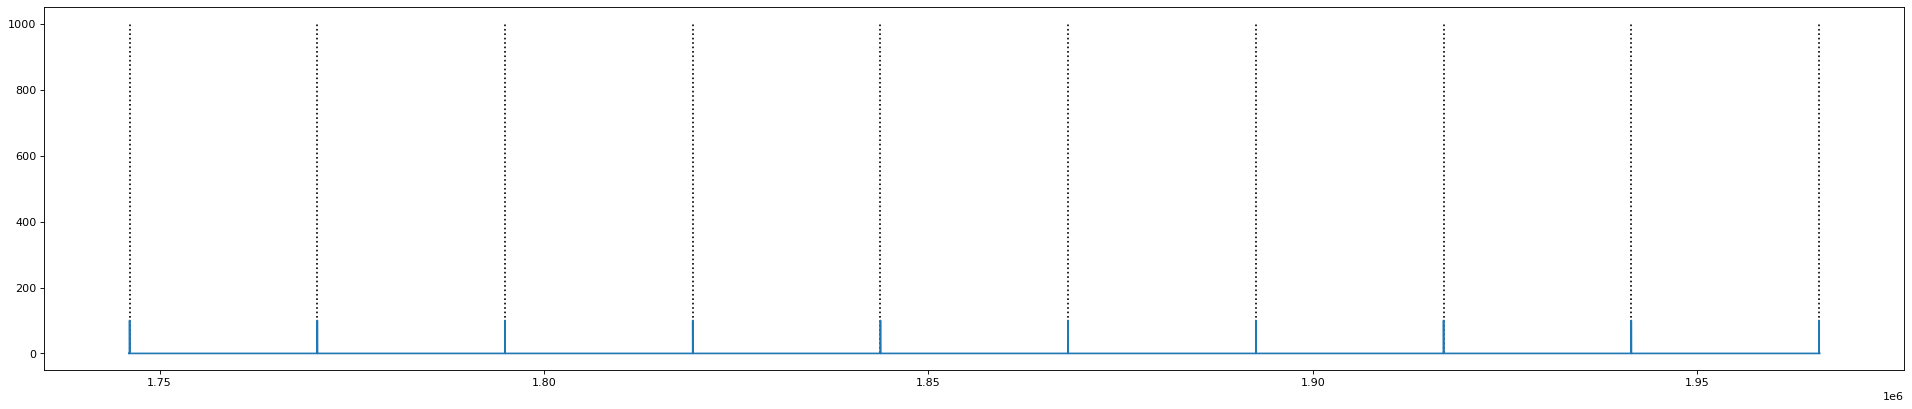

In [56]:
visualize_stims(tdt_data, ch=6, first_stim=1, last_stim=10)

In [40]:
# Remap the stimulation times from TDT time space to SGLX time space, based on sync signal offset and drift between the two systems. 
sglx_stim_times = model.predict(stim_times.reshape((-1, 1)))
sglx_stim_times

array([279.49285332, 283.49282837, 287.49280342, 291.49277847,
       295.49275352, 299.49272857, 303.49270362, 307.49267868,
       311.49265373, 315.49262878, 319.49260383, 323.49257888,
       327.49255393, 331.49252898, 335.49250403, 339.49247908,
       343.49245413, 347.49242919, 351.49240424, 355.49237929,
       359.49235434, 363.49232939, 367.49230444, 371.49227949,
       375.49225454, 393.80790913, 397.80788418, 401.80785923,
       405.80783428, 409.80780933, 413.80778438, 417.80775943,
       421.80773448, 425.80770953, 429.80768458, 433.80765964,
       437.80763469, 441.80760974, 445.80758479, 449.80755984,
       453.80753489, 457.80750994, 461.80748499, 465.80746004,
       469.80743509, 473.80741015, 477.8073852 , 481.80736025,
       485.8073353 , 489.80731035, 525.83523374, 529.83520879,
       533.83518384, 537.8351589 , 541.83513395, 545.835109  ,
       549.83508405, 553.8350591 , 557.83503415, 561.8350092 ,
       565.83498425, 569.8349593 , 573.83493435, 577.83

In [67]:
def matlab_saveas_dialog():
    # Get file from user
    root = Tk()         # create the Tkinter widget
    root.withdraw()     # hide the Tkinter root window

    # Windows specific; forces the window to appear in front
    root.attributes("-topmost", True)

    fullPath = Path(filedialog.asksaveasfilename(title="Save as", defaultextension=".mat", filetypes=(("MATLAB", "*.mat"),)))

    root.destroy()
    
    return fullPath

In [ ]:
# Export the results for use in MATLAB. 
# The names of the SGLX and TDT files used are saved with the data. 
matlab_file = matlab_saveas_dialog()
savemat(matlab_file, {'sglx_stim_times': sglx_stim_times, 'sglx_file': sglx_file.name, 'tdt_file': tdt_file.name})